##  Async Training
The goal here is to compute the average value of all the client.
Each client has a different compute speed than the other clients, depending on the 'compute time' distribution (Normal, Exp, Uniform).
This toy example simulates an asynchronous (federated) learning system.
With some extensions, this should be able to run as a simulation on a GPU.

Author: Bart Cox 13-02-2023

## Import dependencies

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
from tqdm import tqdm

## Aux functions

In [32]:
def create_client(id: int, ct=1):
    return {
        'value': np.random.randint(0, 1000),
        'id':  id,
        'picked': 0,
        'age': 0,
        'ct': ct,
        'ct_left': ct,
    }


def update(central_model, client):
    staleness = central_model['age'] - client['age']
    central_model['age'] += 1
    central_model['value'] += client['value']

    central_model['approx'] = central_model['value'] / central_model['age']
    central_model['difference'] = abs(central_model['true_avg'] - central_model['approx'])
    client['picked'] += 1
    
    client['age'] = central_model['age']
    return central_model, client, staleness

In [78]:
def run_with_compute_times(num_clients, num_rounds, compute_times):
    clients = [create_client(x[0], x[1]) for x in zip(range(num_clients), compute_times)]
    # Calculate the target value
    avg_value = np.mean([x['value'] for x in clients])
    central_model = {
        'value': 0.0,
        'age': 0,
        'approx': 0,
        'difference': 0,
        'error_abs': 0,
        'true_avg': avg_value
    }

    # print('Training')
    data = []
    for _round in tqdm(range(num_rounds)):
        rc = min(clients, key=lambda x:x['ct_left'])
        # Find client the finishes first
        min_ct = rc['ct_left']

        # Update the time for all the clients with the elapsed time of min_ct
        for c in clients:
            c['ct_left'] -= min_ct

        # Perform client server interaction between server and min_ct 
        central_model, rc, staleness = update(central_model, rc)
        # Reset compute time of min_ct
        rc['ct_left'] = rc['ct']
        clients[rc['id']] = rc

        # Gather some statistics
        data.append([central_model['age'], central_model['approx'], 'approx', staleness])
        data.append([central_model['age'], avg_value, 'avg', 0])
        data.append([central_model['age'], abs(avg_value - central_model['approx']), 'error_abs', 0])
    return pd.DataFrame(data, columns=['age', 'value', 'type', 'staleness']) 


def run(num_clients = 100, num_rounds = 1000):

    results = []
    # Normal distribution
    mu, sigma = 15, 3
    ct_normal = np.random.normal(mu, sigma, num_clients)
    df_normal = run_with_compute_times(num_clients, num_rounds, ct_normal)
    results.append([
        f'Normal distribution (mu={mu}, sigma={sigma}), client={num_clients}, rounds={num_rounds}',
        ct_normal,
        df_normal
    ])

    # Exponential
    exp_val = 1
    ct_exp = np.random.exponential(exp_val, num_clients)
    df_exp = run_with_compute_times(num_clients, num_rounds, ct_exp)
    results.append([
        f'Exponential distribution (lambda={exp_val}), client={num_clients}, rounds={num_rounds}',
        ct_exp,
        df_exp
    ])

    # Uniform
    uniform_vals = [1, 20]
    ct_uniform = np.random.uniform(*uniform_vals, num_clients)
    df_uniform = run_with_compute_times(num_clients, num_rounds, ct_uniform)
    results.append([
        f'Uniform distribution (min-max={uniform_vals}), client={num_clients}, rounds={num_rounds}',
        ct_uniform,
        df_uniform
    ])

    # plot results
    for name, ct, df in results:
        fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
        fig.suptitle(name)
        ax[0].set_title('Generated Compute times')
        df_ct = pd.DataFrame(ct, columns=['ct'])
        sns.histplot(ax=ax[0], data=df_ct, x='ct')
        ax[0].set_xlabel('Compute time')
        # sns.histplot(ax=ax[0], data=df_ct, x='ct', bins=20)
        ax[1].set_title('Value approximation')
        local_df = df[df['type']!='error_abs']
        sns.lineplot(ax=ax[1], data=local_df, x='age', y='value', hue='type')
        ax[1].set_xlabel('Model age')
        ax[2].set_title('Error (abs)')
        local_df = df[df['type']=='error_abs']
        sns.lineplot(ax=ax[2], data=local_df, x='age', y='value', hue='type', )
        ax[2].set_xlabel('Model age')
        ax[2].set_yscale('log')
        ax[3].set_title('Model Staleness (in model age)')
        local_df = df[df['type']=='approx']
        sns.histplot(ax=ax[3], data=local_df, x="staleness")
        ax[3].set_xlabel('Staleness')

## Generate results

100%|██████████| 1000/1000 [00:00<00:00, 4198.22it/s]


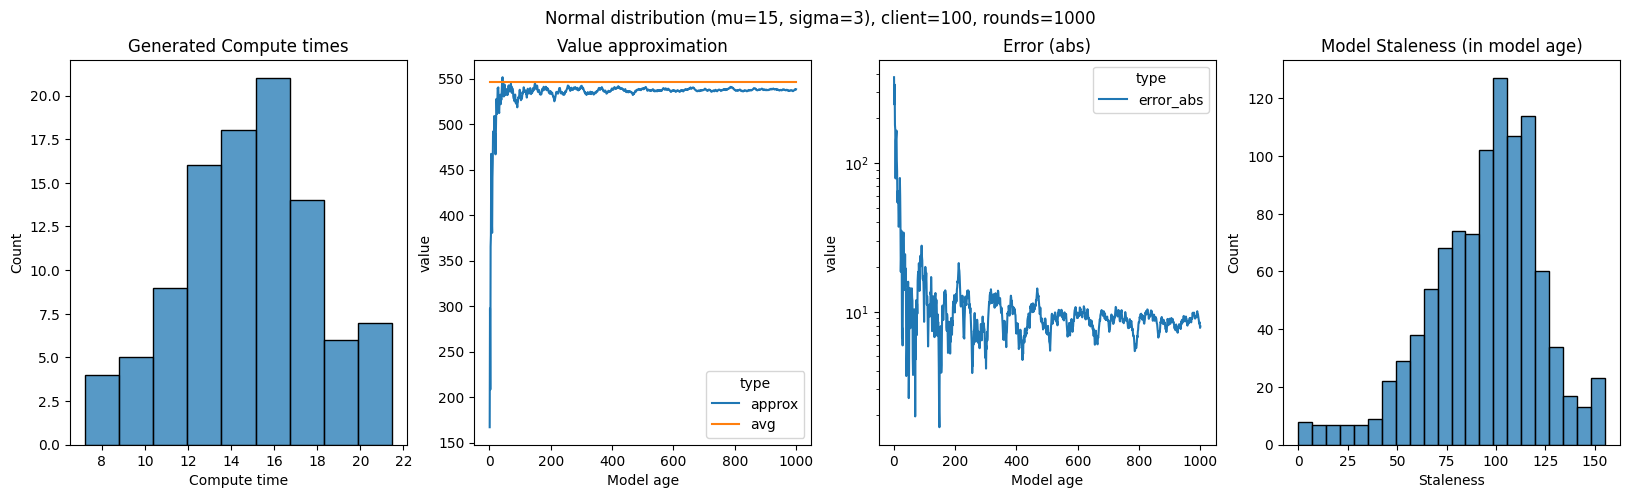

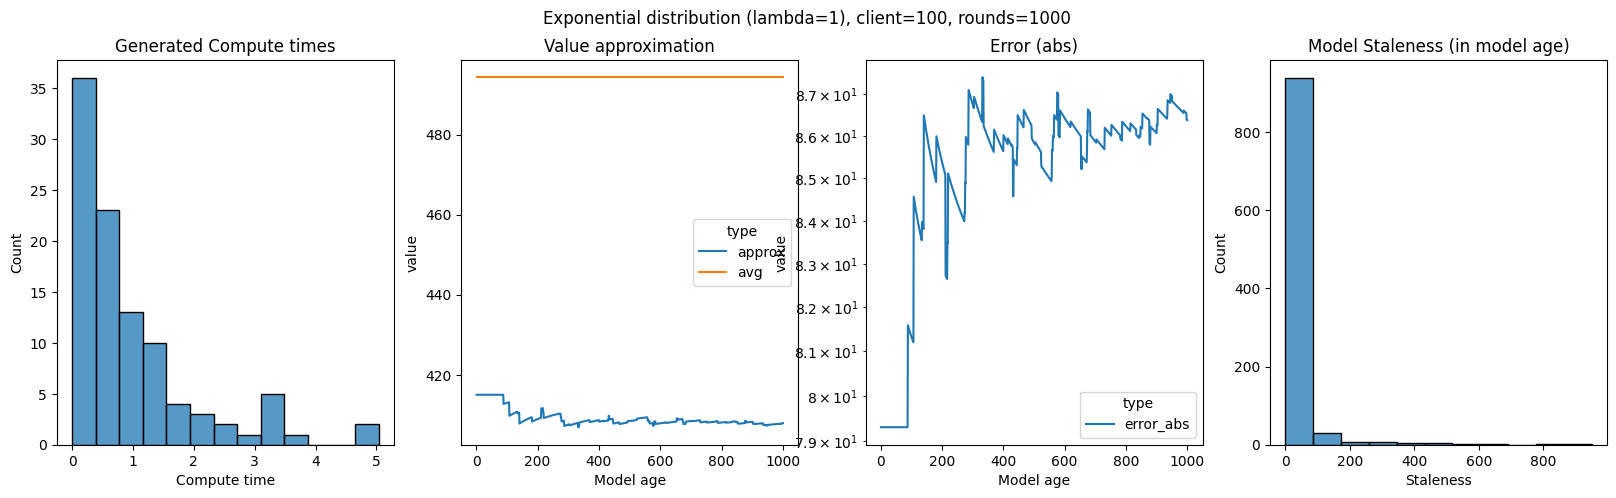

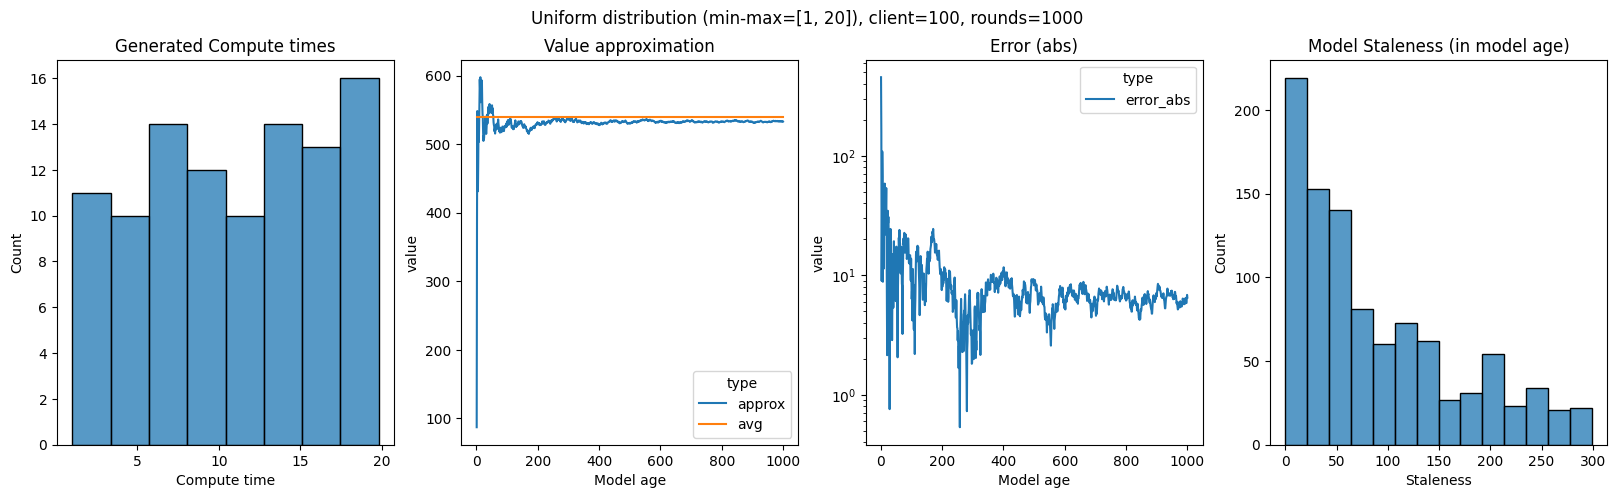

In [79]:
# Run with default values 
# Num_clients = 1000
# Num_round = 10000
run()

100%|██████████| 10000/10000 [00:21<00:00, 459.56it/s]


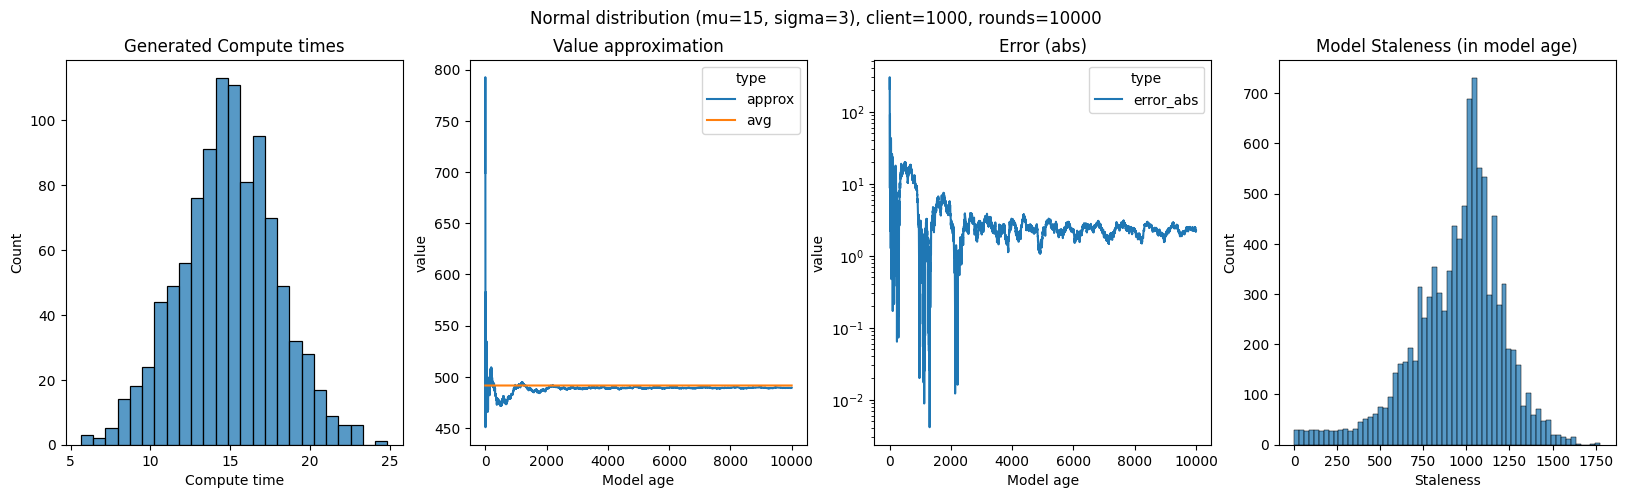

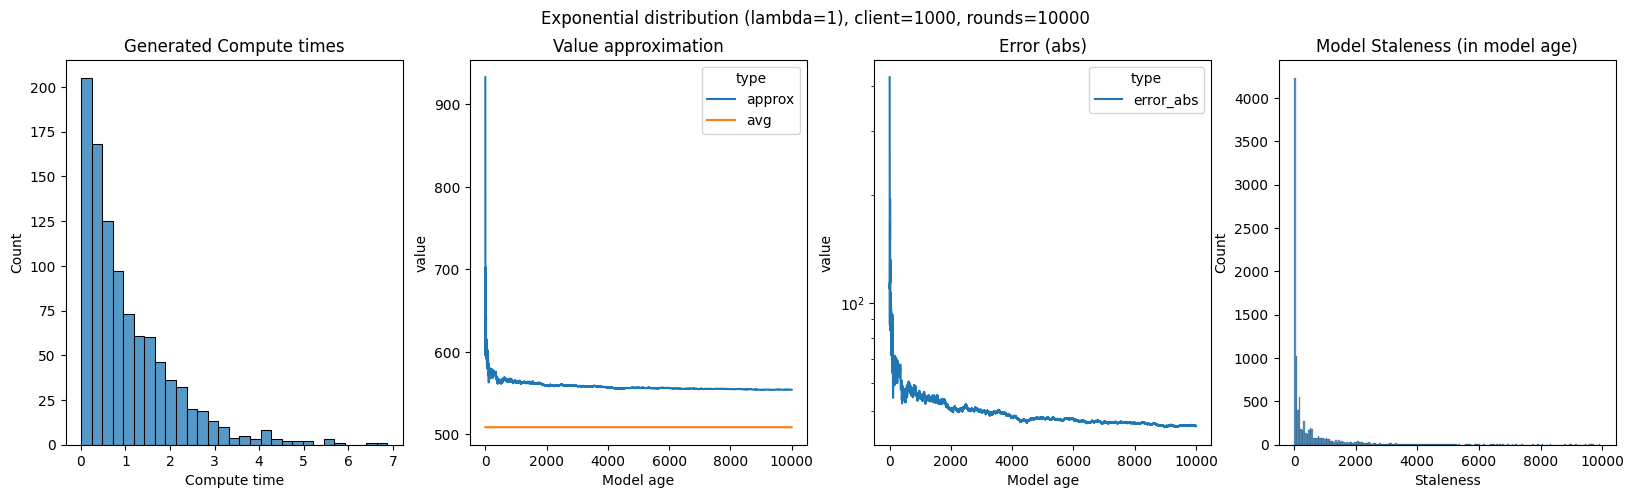

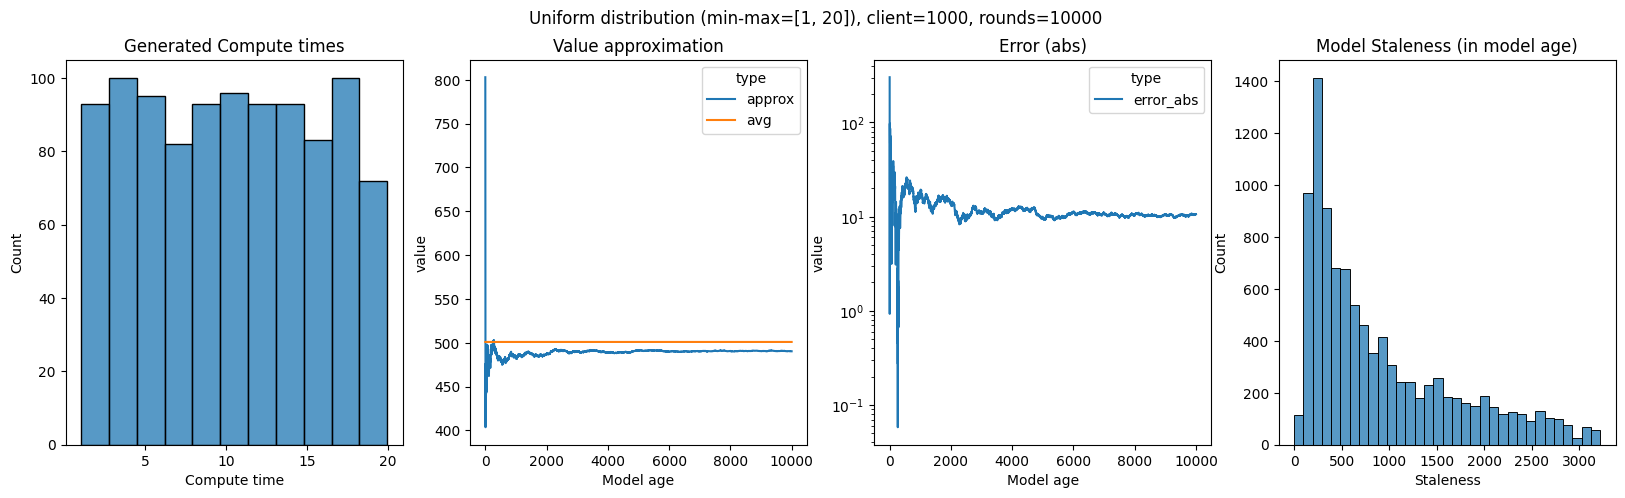

In [80]:
# Run with large number of clients
run(num_clients=1000, num_rounds=10000)